In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input,Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *


In [4]:
data = pd.read_csv('TCS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [5]:
period= 5

In [6]:
# roc
data['roc'] = ((data['Close'] - data['Close'].shift(period)) / data['Close'].shift(period)) * 100


In [7]:
# rsi
data['change_wrt_prevday'] = data['Close']- data['Close'].shift(1)

data['gain']=np.where(data['change_wrt_prevday'] >= 0,data['change_wrt_prevday'], 0)
data['loss']=np.where(data['change_wrt_prevday'] < 0,-data['change_wrt_prevday'], 0)

data['avg_gain'] = data['gain'].rolling(window=period).mean()
data['avg_loss'] = data['loss'].rolling(window=period).mean()

data['rsi'] = 100 - (100 / (1 + (data['avg_gain'] / data['avg_loss'])))

In [8]:
# Bollinger bands

data['SMA'] = data['Close'].rolling(window=period).mean()
data['SD'] = data['Close'].rolling(window=period).std()

data['UB'] = data['SMA'] + 2* data['SD']
data['LB'] = data['SMA'] - 2* data['SD']
data['bb'] = data['UB']-data['LB']

In [9]:
data=data[['Date','Open','High','Low','Volume','Close','Adj Close','roc','rsi','bb']]

In [10]:
data = data.dropna(subset=['rsi'])
data = data.fillna(0)
data=data.reset_index(drop=True)

In [11]:
# data=data.set_index('Date')

In [12]:
data.head()

,Date,Open,High,Low,Volume,Close,Adj Close,roc,rsi,bb
0,2002-08-16,36.275002,38.000000,35.750000,811856,36.375000,25.520840,0.000000,0.000000,6.613487
1,2002-08-19,36.674999,36.674999,35.137501,205880,35.474998,24.889397,-10.642323,0.000000,5.565854
2,2002-08-20,35.724998,38.724998,35.487499,3773624,36.462502,25.582241,-6.894343,21.123046,1.734003
3,2002-08-21,38.474998,39.200001,36.525002,3011064,38.250000,26.836346,4.902292,73.754104,4.038039
4,2002-08-22,39.512501,41.575001,39.312500,6732480,39.900002,27.994001,9.427494,81.755160,7.085164


In [13]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=2, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.wl = self.add_weight(name='wl', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        self.bl = self.add_weight(name='bl', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        self.wp = self.add_weight(name='wp', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        self.bp = self.add_weight(name='bp', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs):
        time_linear = self.wl * inputs + self.bl
        time_periodic = tf.math.sin(tf.matmul(inputs, self.wp) + self.bp)
        return Concatenate()([time_linear, time_periodic])


In [14]:
# feature_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
# time_input_layer = Input(shape=(time_train.shape[1], time_train.shape[2]))
timedata = data['Date'].values.reshape(-1, 1).astype(float)

# Convert time data to TensorFlow tensor
time_tensor = tf.convert_to_tensor(timedata, dtype=tf.float32)

# time_vec = Time2Vec(kernel_size=4)(time_input_layer)
time2vec_layer = Time2Vec(kernel_size=4)
time2vec_output = time2vec_layer(time_tensor)

time2vec_df = pd.DataFrame(time2vec_output.numpy(), columns=[f'Time2Vec{i}' for i in range(time2vec_output.shape[1])])

# Concatenate with the original DataFrame
final_data = pd.concat([data, time2vec_df], axis=1)

print(final_data)
final_data.to_csv('final_data.csv', index=True)

# concatenated_features = Concatenate(axis=-1)([feature_input, time2vec_layer])

           Date         Open         High          Low   Volume        Close  \
0    2002-08-16    36.275002    38.000000    35.750000   811856    36.375000   
1    2002-08-19    36.674999    36.674999    35.137501   205880    35.474998   
2    2002-08-20    35.724998    38.724998    35.487499  3773624    36.462502   
3    2002-08-21    38.474998    39.200001    36.525002  3011064    38.250000   
4    2002-08-22    39.512501    41.575001    39.312500  6732480    39.900002   
...         ...          ...          ...          ...      ...          ...   
5159 2024-07-22  4299.950195  4319.950195  4265.000000  1896386  4287.350098   
5160 2024-07-23  4283.000000  4361.700195  4266.299805  2365208  4302.350098   
5161 2024-07-24  4287.500000  4339.100098  4268.100098  1809793  4306.250000   
5162 2024-07-25  4295.000000  4343.000000  4274.200195  2810342  4322.500000   
5163 2024-07-26  4350.000000  4422.450195  4337.049805  3552210  4387.850098   

        Adj Close        roc        rsi

In [15]:
final_data=final_data.drop(['Date'],axis=1)

In [16]:
final_data

,Open,High,Low,Volume,Close,Adj Close,roc,rsi,bb,Time2Vec0,Time2Vec1,Time2Vec2,Time2Vec3,Time2Vec4,Time2Vec5,Time2Vec6,Time2Vec7
0,36.275002,38.000000,35.750000,811856,36.375000,25.520840,0.000000,0.000000,6.613487,-2.624054e+16,-2.188048e+16,2.834034e+16,-3.114698e+16,-0.159940,0.123224,0.532826,0.925822
1,36.674999,36.674999,35.137501,205880,35.474998,24.889397,-10.642323,0.000000,5.565854,-2.624714e+16,-2.188599e+16,2.834747e+16,-3.115483e+16,0.606829,0.658319,0.026351,-0.999998
2,35.724998,38.724998,35.487499,3773624,36.462502,25.582241,-6.894343,21.123046,1.734003,-2.624935e+16,-2.188783e+16,2.834985e+16,-3.115744e+16,0.337180,0.640502,-0.780224,0.981284
3,38.474998,39.200001,36.525002,3011064,38.250000,26.836346,4.902292,73.754104,4.038039,-2.625155e+16,-2.188966e+16,2.835223e+16,-3.116005e+16,0.979645,-0.843835,0.981453,0.995511
4,39.512501,41.575001,39.312500,6732480,39.900002,27.994001,9.427494,81.755160,7.085164,-2.625375e+16,-2.189150e+16,2.835461e+16,-3.116267e+16,0.994383,-0.831031,-0.780355,-0.995311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,4299.950195,4319.950195,4265.000000,1896386,4287.350098,4287.350098,2.471346,77.311219,283.434639,-4.388325e+16,-3.659173e+16,4.739484e+16,-5.208853e+16,-0.906706,-0.859135,-0.692844,-0.862002
5160,4283.000000,4361.700195,4266.299805,2365208,4302.350098,4302.350098,3.193656,85.122760,224.435438,-4.388546e+16,-3.659356e+16,4.739722e+16,-5.209114e+16,-0.991916,-0.870889,0.997997,-0.682104
5161,4287.500000,4339.100098,4268.100098,1809793,4306.250000,4306.250000,3.058546,84.690648,40.670382,-4.388766e+16,-3.659540e+16,4.739960e+16,-5.209375e+16,0.988505,0.680006,0.825731,-0.445798
5162,4295.000000,4343.000000,4274.200195,2810342,4322.500000,4322.500000,0.161050,55.485587,50.186441,-4.388986e+16,-3.659724e+16,4.740198e+16,-5.209637e+16,0.987798,0.696998,-0.227825,-0.906096


In [17]:
features = final_data.columns.tolist()
target='Close'

In [18]:
sequence_length = 100
X = []
y = []

for i in range(len(final_data) - sequence_length):
    X.append(final_data[features].iloc[i:i+sequence_length].values)
    y.append(final_data[target].iloc[i+sequence_length])

In [19]:
X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [20]:
X.shape

(5064, 100, 17)

In [23]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
# scaler_time = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)
# time_input_scaled = scaler_time.fit_transform(time_input.reshape(-1, time_input.shape[2])).reshape(time_input.shape)

In [24]:
s = 0.9
X_train = X_scaled[:int(s*len(X))]
X_test = X_scaled[int(s*len(X)):]
y_train = y_scaled[:int(s*len(y))]
y_test = y_scaled[int(s*len(y)):]
# time_train = time_input_scaled[:int(s*len(time_input))]
# time_test = time_input_scaled[int(s*len(time_input)):]


In [26]:
X_train.shape

(4557, 100, 17)

In [27]:
model=Sequential()
model.add(LSTM(128,return_sequences=False,input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history=model.fit(X_train,y_train, batch_size = 128,epochs = 200,validation_split=0.2, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2134 - val_loss: 0.0213
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0226
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0085 - val_loss: 0.0167
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0068 - val_loss: 0.0192
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0064 - val_loss: 0.0176
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0053 - val_loss: 0.0301
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - val_loss: 0.0244
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0196
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0244
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 0.0138
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0133
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

In [29]:
# y_test_pred_scaled = model.predict([X_scaled,time_input_scaled])
y_test_pred_scaled = model.predict(X_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_scaled)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


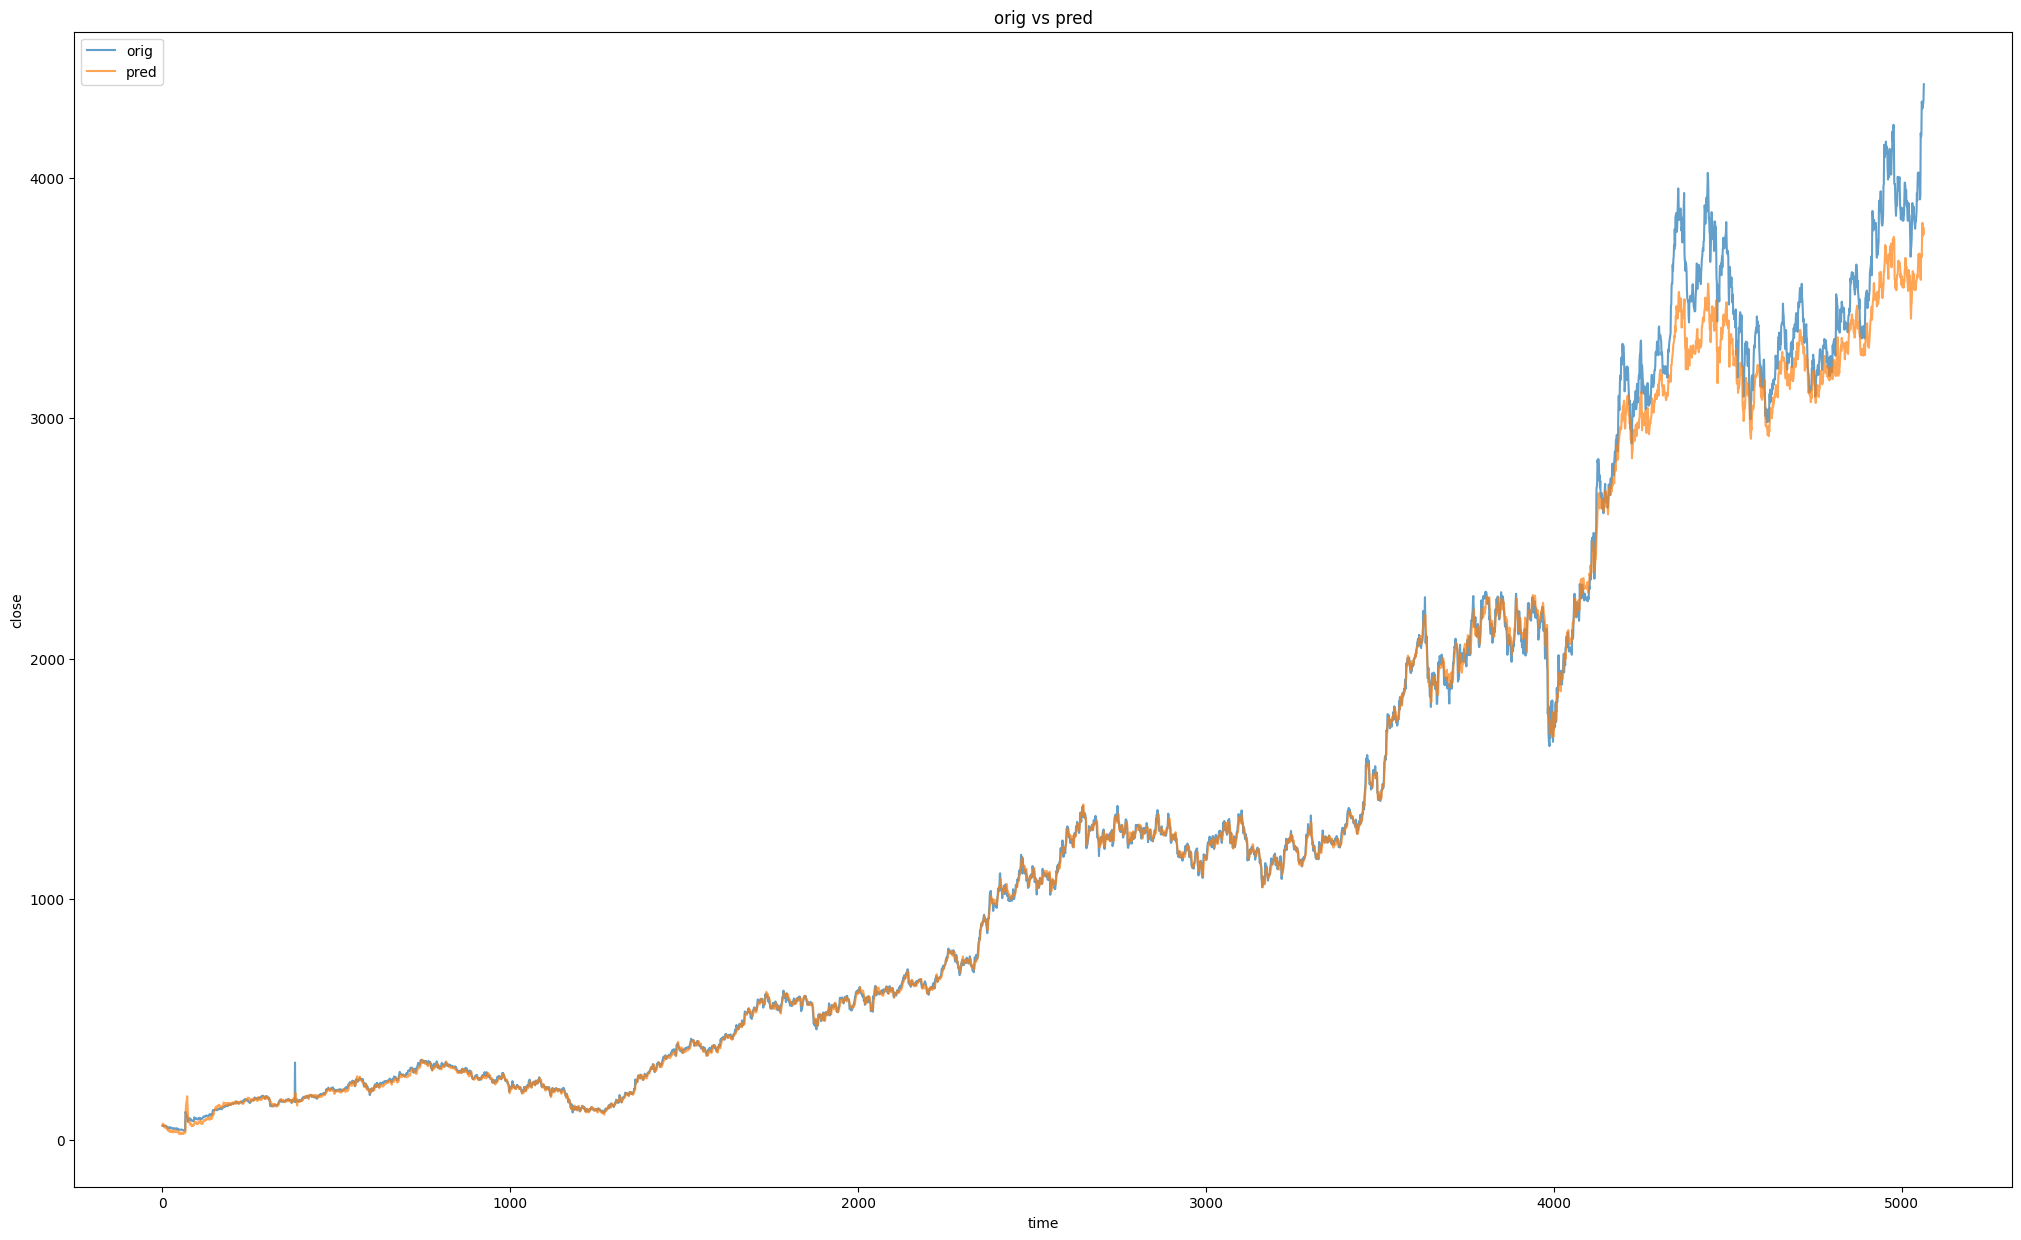

In [30]:
plt.figure(figsize=(25, 15))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

In [31]:
# y_test_pred_scaled = model.predict([X_test,time_test])
y_test_pred_scaled = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


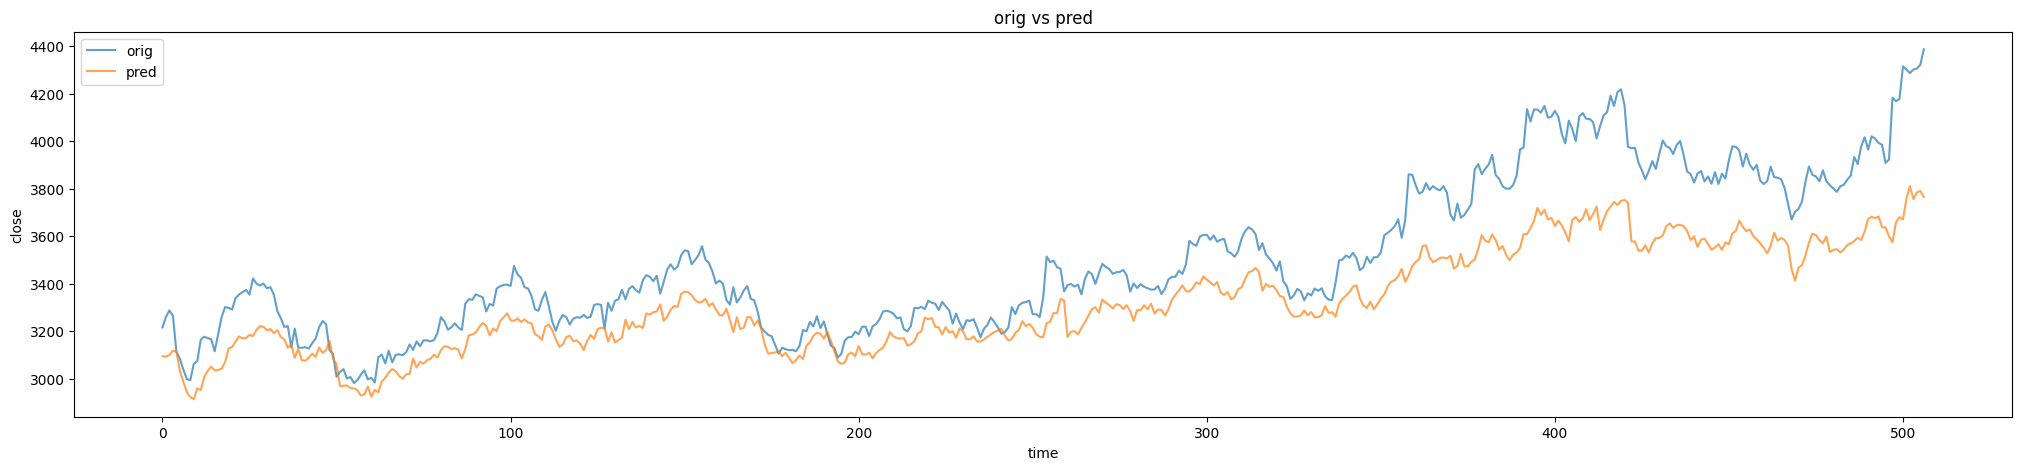

In [32]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()